# Procesamiento Digital de Señales <img src="./logo_UTN.svg" align="right" width="150"/>
## Alumno: Emanuel Olay
### Tarea Semanal: 9

In [48]:
# import warnings
# warnings.filterwarnings('ignore')


import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.interpolate
import scipy.signal as sig
import scipy.io as sio
from scipy.fft import fft, fftshift
import matplotlib.patches as mpatches
from pandas import DataFrame
from IPython.display import HTML

width=15
height=5
plt.rcParams['figure.figsize'] = [width, height]

In [49]:
plt.close('all')

#sio.whosmat('ECG_TP4.mat')
mat_struct= sio.loadmat('ECG_TP4.mat')

fs= 1000 #Hz
figura=0

ecg= mat_struct['ecg_lead']

qrs_detections = mat_struct['qrs_detections']

patron_normal= mat_struct['heartbeat_pattern1']

patron_ventricular= mat_struct['heartbeat_pattern2']

N=len(ecg)

muestras_tot=np.arange(0,N,1)


##Delta muestras por debajo del pico
d_muestras1=200
##Delta muestras por arriba del pico
d_muestras2=300

ventana_temporal=np.arange(0,d_muestras1+d_muestras2,1)

In [50]:
#preparo el ecg para trabajar
latidos_matrix= [ (ecg[int(i-d_muestras1):int(i+d_muestras2)]) for i in qrs_detections ]
array_latidos=np.hstack(latidos_matrix)
#Los latidos estan a distintas alturas entonces sincronizo en y
#Tome la decision de restar la media de todo el experimento lo que en la mayoria
#de los casos deberia ser correcto
array_latidos=array_latidos - np.mean(array_latidos,axis=0)

Text(0, 0.5, 'Amplitud')

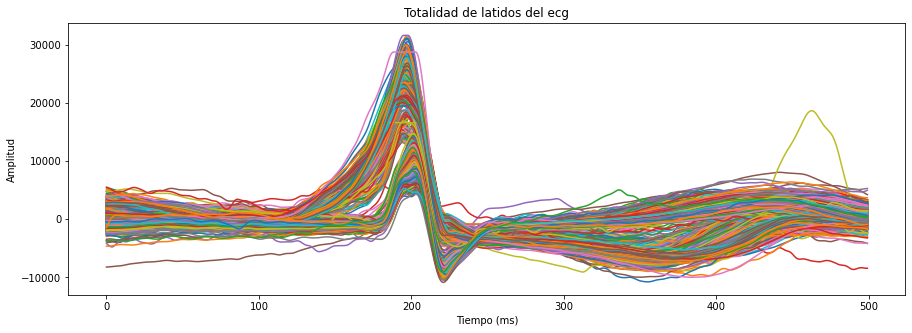

In [51]:
plt.figure(figura)
figura+=1
plt.plot(ventana_temporal, array_latidos)
plt.title('Totalidad de latidos del ecg')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Amplitud')

Text(0, 0.5, 'Amplitud normalizada')

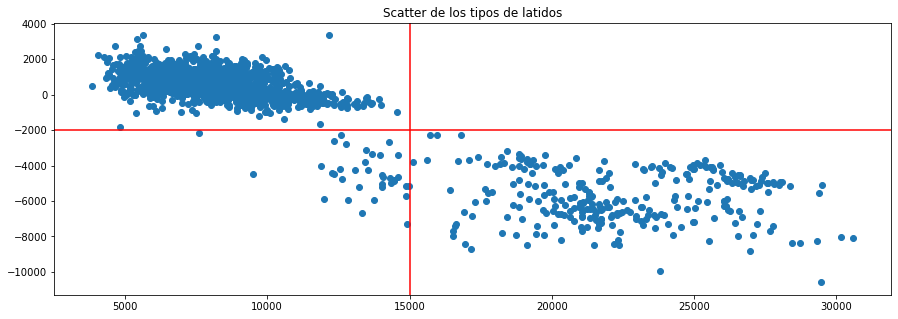

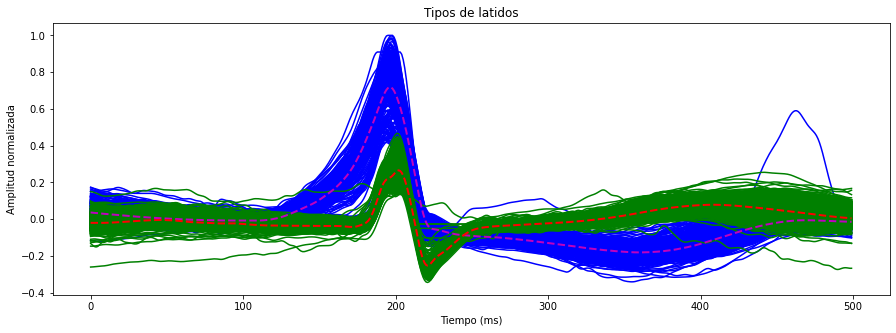

In [52]:
#Busco separar los latidos ventriculares y los latidos normales en 2 grupos
maximos = array_latidos[200,:]
minimos = array_latidos[350,:]

#Es pico si supera
pico = 15000
#Es valle si cae por debajo
valle = -2000

plt.figure(figura)
figura+=1
plt.scatter(maximos,minimos)
plt.axvline(x=pico, color='r')
plt.axhline(y=valle, color='r')
plt.title('Scatter de los tipos de latidos')

indice_normales = np.bitwise_and(maximos < pico, minimos > valle)
##Todas las qrs detections que no cayeron en mi agrupacion anterior
indice_ventriculares = ~indice_normales


latidos_norm = array_latidos[:,indice_normales]
latidos_vent = array_latidos[:,indice_ventriculares]
normal_medio = np.mean(latidos_norm , axis=1)
ventricular_medio = np.mean(latidos_vent , axis=1)

plt.figure(figura)
figura+=1
plt.plot(latidos_vent/np.amax(array_latidos), 'b')
plt.plot(latidos_norm/np.amax(array_latidos), 'g')
plt.plot(ventricular_medio/np.amax(array_latidos), '--m',lw=2)
plt.plot(normal_medio/np.amax(array_latidos), '--r',lw=2)
plt.title('Tipos de latidos')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Amplitud normalizada')


# Por consigna:
Trabajamos sobre los primeros 50 latidos que son los mas limpios para hacer un analisis espectral

Text(0, 0.5, 'Amplitud normalizada')

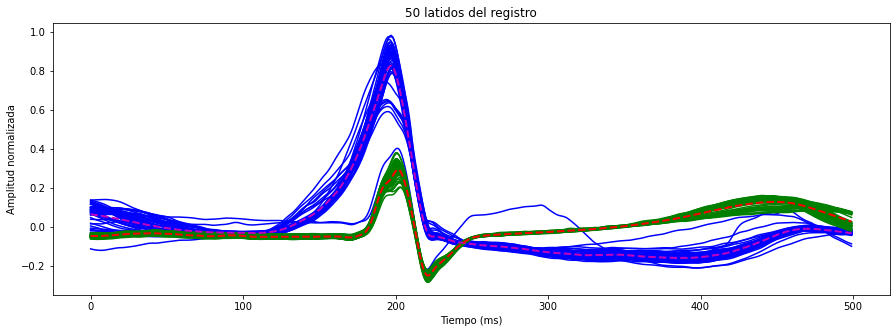

In [53]:
cantidad=50
##Levnato 50 de cada tipo de latido
primeros_vent = latidos_vent[:,0:cantidad]
primeros_norm = latidos_norm[:,0:cantidad]

vent_prom = np.mean(primeros_vent, axis=1)
norm_prom = np.mean(primeros_norm, axis=1)

plt.figure(figura)
figura+=1
plt.plot(primeros_vent/np.amax(array_latidos), 'b')
plt.plot(primeros_norm/np.amax(array_latidos), 'g')
plt.plot(vent_prom/np.amax(array_latidos), '--m',lw=2)
plt.plot(norm_prom/np.amax(array_latidos), '--r',lw=2)
plt.title('{:1.0f} latidos del registro'.format(cantidad))
plt.xlabel('Tiempo (ms)')
plt.ylabel('Amplitud normalizada')

(0.0, 20.0)

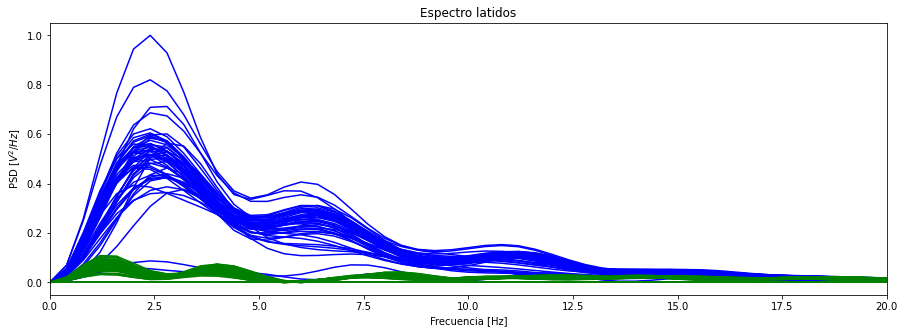

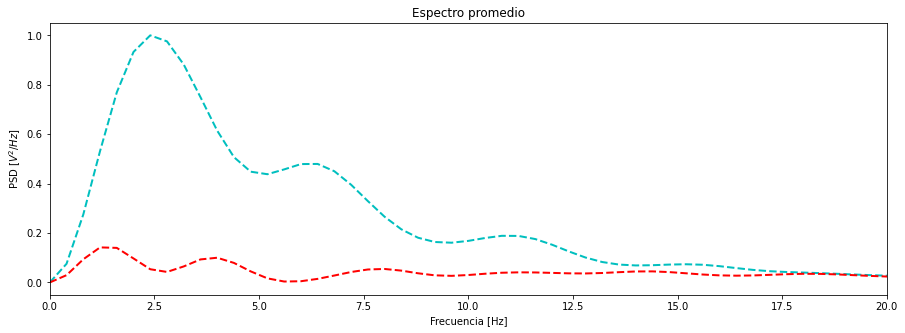

In [57]:
##Padeo con 0 y aplico welch para calcular el espectro
#Padeo a ambos lados
Padeo=1000
primeros_vent_padded=np.pad(primeros_vent, (Padeo, Padeo), 'constant', constant_values=(0, 0))
primeros_norm_padded=np.pad(primeros_norm, (Padeo, Padeo), 'constant', constant_values=(0, 0))

N_padded = len(primeros_vent_padded)
fw_v, Pw_v = sig.welch(primeros_vent_padded, fs, nperseg = N_padded, axis=0)
fw_n, Pw_n = sig.welch(primeros_norm_padded, fs, nperseg = N_padded, axis=0)

#Normalizo por potencia maxima que deberia ser ventricular
norm1 = np.amax(Pw_v)

Pw_v_prom = np.mean(Pw_v,axis=1)
Pw_n_prom = np.mean(Pw_n,axis=1)

norm2= np.amax(Pw_v_prom)
plt.figure(figura)
figura+=1
plt.plot(fw_v,Pw_v/norm1, 'b')
plt.plot(fw_n,Pw_n/norm1, 'g')
plt.title('Espectro latidos')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [$V^{2}/Hz$]')
plt.xlim(0,20)

plt.figure(figura)
figura+=1

plt.plot(fw_v,Pw_v_prom/norm2, '--c',lw=2)
plt.plot(fw_n,Pw_n_prom/norm2, '--r',lw=2)
plt.title('Espectro promedio')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [$V^{2}/Hz$]')
plt.xlim(0,20)

# Calculo el ancho de banda de mis signals
Utilizo mis dos espectros promedio ya que no poseen el ruido que puede haber de muestra a muestra.

Text(-20, 20, 'BW_n = 25.2 Hz')

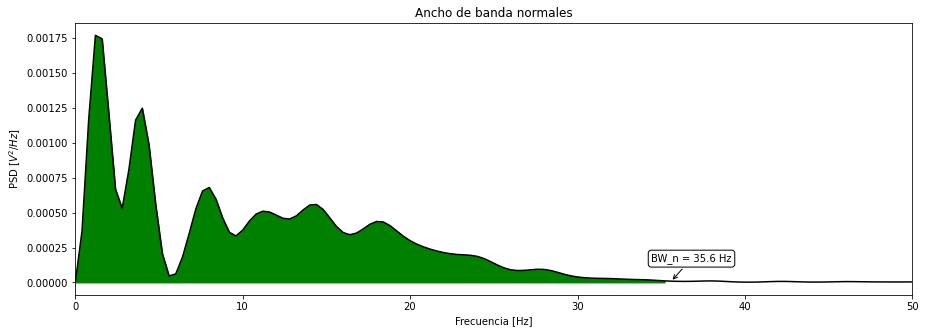

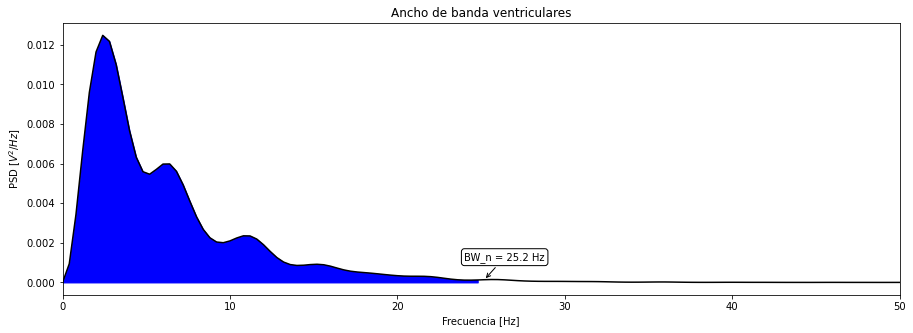

In [55]:
#Propongo un porcentaje del total de la energia bajo la curva del PSD
percent = 0.99

#Integro y normalizo respecto del total de la energia bajo al curva
Pot_n = np.cumsum(Pw_n_prom)/np.sum(Pw_n_prom)
corte_n = np.where(Pot_n >percent)[0][0]
#Integro y normalizo respecto del total de la energia bajo al curva
Pot_v = np.cumsum(Pw_v_prom)/np.sum(Pw_v_prom)
corte_v = np.where(Pot_v >percent)[0][0]

plt.figure(figura)
figura+=1
plt.plot(fw_n,Pw_n_prom/norm, 'k')
plt.fill_between(fw_n, 0, Pw_n_prom/norm, where = fw_v < fw_v[corte_n], color='green')
plt.title('Ancho de banda normales')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [$V^{2}/Hz$]')
plt.xlim(0,50)

plt.annotate(   "BW_n = {:3.1f} Hz".format(fw_n[corte_n]),
                xy=(fw_n[corte_n], Pw_n_prom[corte_n]/norm),
                xytext=(-20,20),
                textcoords="offset points",
                bbox=dict(boxstyle="round", fc="w"),
                arrowprops=dict(arrowstyle='->')
)

plt.figure(figura)
figura+=1
plt.plot(fw_v,Pw_v_prom/norm, 'k')
plt.fill_between(fw_n, 0, Pw_v_prom/norm, where = fw_v < fw_v[corte_v], color='blue')
plt.title('Ancho de banda ventriculares')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [$V^{2}/Hz$]')
plt.xlim(0,50)

plt.annotate(   "BW_n = {:3.1f} Hz".format(fw_v[corte_v]),
                xy=(fw_v[corte_v], Pw_v_prom[corte_v]/norm),
                xytext=(-20,20),
                textcoords="offset points",
                bbox=dict(boxstyle="round", fc="w"),
                arrowprops=dict(arrowstyle='->')
)

# Conclusion
Con las herramientas que nos fueron proporcionadas a lo largo del curso pudimos levantar todas las muestras de un ECG, a partir de esta informacion y las detecciones pudimos observar el rango de muestras en el cual se desarrollan los latidos.<br>
Una vez detectados los latidos los trabajamos para tratar de visualizarlos correctamente quitandole por ejemplo el nivel de continua y separarlos segun sus caracteristicas morfologicas.<br>
Caracteristicas como por ejemplo que los latidos ventriculares no tienen un valle acentuado como si lo tienen los latidos normales.<br>
Luego utilizando el periodograma de Welch podemos visualizar sus lobulos principales, es decir para que frecuencias hay mas energia e integrando la energia bajo las curvas podemos determinar el ancho de banda que utiliza cada tipo de latido.<br>